<a href="https://colab.research.google.com/github/AlcirCastro/Trabalho-Final-IA/blob/main/trabalho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
!pip install LTNtorch

In [66]:
import torch
import numpy as np
import ltn
import matplotlib.pyplot as plt

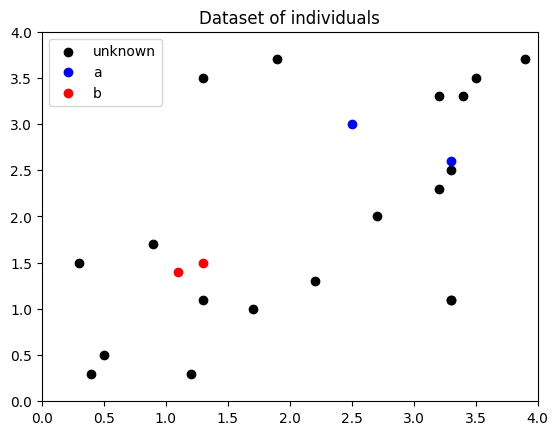

In [67]:
points = np.array(
        [[0.4,0.3], [1.2,0.3], [2.2,1.3], [1.7,1.0], [0.5,0.5], [0.3, 1.5], [1.3, 1.1], [0.9, 1.7],
        [3.4,3.3], [3.2,3.3], [3.2,2.3], [2.7,2.0], [3.5,3.5], [3.3, 2.5], [3.3, 1.1], [1.9, 3.7], [1.3, 3.5],
        [3.3, 1.1],[3.9, 3.7]])
point_a = [[3.3, 2.5], [2.6, 3.0], [2.7, 3.8], [3.0, 3.5], [3.2, 3.2]]
point_b = [[1.3, 1.1], [1.5, 1.4], [1.7, 1.9], [1.9, 2.3], [1.4, 2.8]]
fig, ax = plt.subplots()
ax.set_xlim(0, 4)
ax.set_ylim(0, 4)
ax.scatter(points[:,0], points[:,1], color="black", label="unknown")
ax.scatter(point_a[0], point_a[1], color="blue", label="a")
ax.scatter(point_b[0], point_b[1], color="red", label="b")
ax.set_title("Dataset of individuals")
plt.legend();

In [68]:
# Predicate C
class ModelC(torch.nn.Module):
    def __init__(self):
        super(ModelC, self).__init__()
        self.elu = torch.nn.ELU()
        self.softmax = torch.nn.Softmax(dim=1)
        self.dense1 = torch.nn.Linear(2, 5)
        self.dense2 = torch.nn.Linear(5, 5)
        self.dense3 = torch.nn.Linear(5, 2)

    def forward(self, x, l):
        """x: point, l: one-hot label"""
        x = self.elu(self.dense1(x))
        x = self.elu(self.dense2(x))
        prob = self.softmax(self.dense3(x))
        return torch.sum(prob * l, dim=1)

C = ltn.Predicate(ModelC())

# Predicate Sim
Sim = ltn.Predicate(func=lambda u, v: torch.exp(-1. * torch.sqrt(torch.sum(torch.square(u - v), dim=1))))

In [69]:
# variables and constants
x1 = ltn.Variable("x1", torch.tensor(points))
x2 = ltn.Variable("x2", torch.tensor(points))
a = ltn.Constant(torch.tensor(point_a))
b = ltn.Constant(torch.tensor(point_b))
l_a = ltn.Constant(torch.tensor([1, 0]))
l_b = ltn.Constant(torch.tensor([0, 1]))
l = ltn.Variable("l", torch.tensor([[1, 0], [0, 1]]))

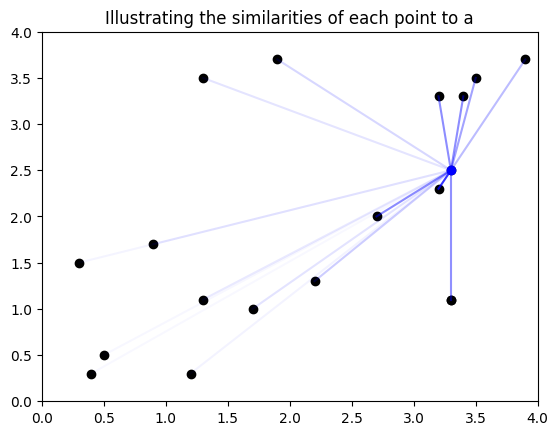

In [62]:
similarities_to_a = Sim(x1, a).value
fig, ax = plt.subplots()
ax.set_xlim(0, 4)
ax.set_ylim(0, 4)
ax.scatter(points[:,0], points[:,1], color="black")
ax.scatter(a.value[0], a.value[1], color="blue")
ax.set_title("Illustrating the similarities of each point to a")
for i, sim_to_a in enumerate(similarities_to_a):
    plt.plot([points[i,0], a.value[0]], [points[i,1],a.value[1]], alpha=float(sim_to_a.numpy()), color="blue")

In [70]:
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
And = ltn.Connective(ltn.fuzzy_ops.AndProd())
Or = ltn.Connective(ltn.fuzzy_ops.OrProbSum())
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
Equiv = ltn.Connective(ltn.fuzzy_ops.Equiv(ltn.fuzzy_ops.AndProd(), ltn.fuzzy_ops.ImpliesReichenbach()))
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=6), quantifier="e")

In [71]:
# by default, SatAgg uses the pMeanError
sat_agg = ltn.fuzzy_ops.SatAgg()

# we need to learn the parameters of the predicate C
optimizer = torch.optim.Adam(C.parameters(), lr=0.001)

for epoch in range(2000):
    optimizer.zero_grad()
    loss = 1. - sat_agg(
        C(a, l_a),
        C(b, l_b),
        Forall([x1, x2, l], Implies(Sim(x1, x2), Equiv(C(x1, l), C(x2, l))))
    )
    loss.backward()
    optimizer.step()
    if epoch%200 == 0:
        print("Epoch %d: Sat Level %.3f "%(epoch, 1 - loss.item()))
print("Training finished at Epoch %d with Sat Level %.3f" %(epoch, 1 - loss.item()))

RuntimeError: shape '[]' is invalid for input of size 2

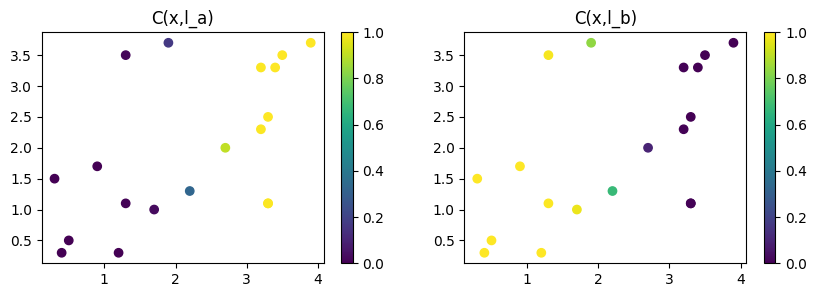

In [65]:
fig = plt.figure(figsize=(10, 3))
fig.add_subplot(1, 2, 1)
plt.scatter(x1.value[:, 0], x1.value[:, 1], c=C(x1, l_a).value.detach().numpy(), vmin=0, vmax=1)
plt.title("C(x,l_a)")
plt.colorbar()
fig.add_subplot(1, 2, 2)
plt.scatter(x1.value[:, 0], x1.value[:, 1], c=C(x1, l_b).value.detach().numpy(), vmin=0, vmax=1)
plt.title("C(x,l_b)")
plt.colorbar()
plt.show();